## Where in Raleigh, NC Should I Open an Italian Restaurant?

### Introduction

#### My friend is looking to move out from New York City as he gets closer to retirement.  . He has been in the restaurant business for 20 years and has owned several Italian Restaurants in New York.  
#### He wants to move to a quieter town, but he still needs income.  He has asked me to research other cities to see which towns are need of a good Italian restaurant.  I am currently looking at Raleigh North Carolina.  
#### I decided to research Italian restaurant competitors, Cafes, Shopping, and Nightlife.  I am most interested in finding places from the different categories and seeing where in Raleigh are the greatest concentration of other Italian Restaurants located in conjunction with other popular cafes, shopping, and Nightlife venues.

### Data Sets

#### The data that will be using are from Italian Restaurant Venues, Cafes, Shopping, and the Nightlife in the city of Raleigh.  
#### We will utilize the data from Foursquare using its API and collect it into a datasource for feature selection.  
#### We will look at features such as name, categories, address, cross street, latitude, longitude.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
!pip install folium
import folium # map rendering library

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

print('Libraries imported.')

    100% |████████████████████████████████| 102kB 15.2MB/s 
  Running setup.py bdist_wheel for geographiclib ... done
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/99/45/d1/14954797e2a976083182c2e7da9b4e924509e59b6e5c661061
Successfully built geographiclib
    100% |████████████████████████████████| 92kB 5.2MB/s 
Libraries imported.


### Tranform the data into a pandas dataframe

In [2]:
# define the dataframe columns
column_names = ['ZipCode'] 

# instantiate the dataframe: since Raleigh only has 15 zip codes, I enetered them manually
df_raleigh = pd.DataFrame(['27601', '27603', '27604', '27605', '27606', '27607', '27608', '27609', '27610', '27612', '27613', '27614', '27615', '27616', '27617'], columns=column_names)
df_raleigh.head(10)

,ZipCode
0,27601
1,27603
2,27604
3,27605
4,27606
5,27607
6,27608
7,27609
8,27610
9,27612


### Adding Geographical coordinates of the Raleigh Zip Codes

In [3]:
API_key = '##########################################'
latitudes=[] # List for the latitudes
longitudes=[] # List for the longitudes

for i in df_raleigh['ZipCode']: # Iterating through Zip codes to collect the locations data
    url ="https://maps.googleapis.com/maps/api/geocode/json?key={}&address={}".format(API_key,i)
    response = requests.get(url).json() # get response
    geographical_data = response['results'][-1]['geometry']['location'] # get geographical coordinates
    latitudes.append(geographical_data['lat'])
    longitudes.append(geographical_data['lng'])

df_raleigh['Latitude'] = latitudes # Adding a column for Latitude  

df_raleigh['Longitude'] = longitudes # Adding a column for Longitude
df_raleigh.rename(columns={'ZipCode': 'location.postalCode', 'Latitude': 'location.lat', 'Longitude': 'location.lng'}, inplace=True)

In [4]:
df_raleigh

,location.postalCode,location.lat,location.lng
0,27601,35.774430,-78.631362
1,27603,35.663112,-78.679584
2,27604,35.815048,-78.577441
3,27605,35.792752,-78.654058
4,27606,35.741830,-78.713608
5,27607,35.801914,-78.687536
6,27608,35.805945,-78.651221
7,27609,35.840924,-78.622850
8,27610,35.748243,-78.554728
9,27612,35.853327,-78.696597


### Raleigh Zip codes for Folium Map

In [5]:
address = 'Raleigh,North Carolina'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The geograpical coordinate of Raleigh,North Carolina are {}, {}.'.format(latitude_x, longitude_y))

The geograpical coordinate of Raleigh,North Carolina are 35.7803977, -78.6390989.


### Draw Folium Map of Raleigh Zip Codes

In [6]:
# create map of Raleigh using latitude and longitude values
map_raleigh = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)
# add markers to map
for lat, lng, zipc in zip(df_raleigh['location.lat'], df_raleigh['location.lng'], df_raleigh['location.postalCode']):
    label = '{}'.format(zipc)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7).add_to(map_raleigh) 
map_raleigh

### Get venues for specific category from all of the Zip code areas of Raleigh using the Foursquare API

In [7]:
def get_nearby_venues(categoryId,lat,lng):
    CLIENT_ID = '################################################' # your Foursquare ID
    CLIENT_SECRET = '################################################' # your Foursquare Secret
    VERSION = '20170511' # Foursquare API version
    RADIUS = 47105.50  # 29.72 miles
    LIMIT = 100
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        categoryId,
        RADIUS,
        LIMIT,)
    results = requests.get(url).json()
    venues = results['response']['venues']
    nearby_venues = json_normalize(venues)
    
    # filter to return only names that start with the Raleigh 276 zip code prefix
    nearby_venues['location.postalCode'].fillna('27601',inplace=True)
    raleigh_venues = nearby_venues[nearby_venues['location.postalCode'].str.contains('276')]
    raleigh_venues = raleigh_venues[['name','location.address','location.postalCode','location.crossStreet','location.lat','location.lng']]
    raleigh_venues.sort_values(by='location.postalCode',inplace=True)
    raleigh_venues.reset_index(drop=True,inplace=True)
    return raleigh_venues

In [8]:
# Category IDs for Italian Restaurant, caffes, shopping, and nightlife respectively
categories = {'Italian Restaurant': '4bf58dd8d48988d110941735', 
              'Caffes': '4bf58dd8d48988d1e0931735', 'Shopping': '4d4b7105d754a06378d81259', 'Nightlife': '4d4b7105d754a06376d81259'}

In [9]:
columns = ['name','location.address','location.postalCode','location.crossStreet','location.lat','location.lng','category']
raleigh_venues_comb_df = pd.DataFrame(columns=columns)
for catname, catid in categories.items():
    raleigh_venues = get_nearby_venues(catid, latitude_x, longitude_y)
    raleigh_venues['category'] = catname
    raleigh_venues_comb_df = raleigh_venues_comb_df.append(raleigh_venues, ignore_index=True)
    #print(raleigh_venues.to_string())
raleigh_venues_comb_df

,name,location.address,location.postalCode,location.crossStreet,location.lat,location.lng,category
0,Gravy,135 S Wilmington St,27601,btw E Morgan St & W Hargett St,35.778482,-78.638143,Italian Restaurant
1,Caffé Luna,136 E Hargett St,27601,N Blount St.,35.778086,-78.636749,Italian Restaurant
2,Jimmy V's Osteria + Bar,420 Fayetteville St,27601,NaN,35.774977,-78.639655,Italian Restaurant
3,Oak City Meatball Shoppe,180 E Davie St,27601,NaN,35.775520,-78.637234,Italian Restaurant
4,Vic's Ristorante Italiano & Pizzeria,331 Blake St,27601,NaN,35.775933,-78.635778,Italian Restaurant
5,La Piazza Italian Restaurant,7277 NC Highway 42,27603,NC Hwy 50,35.591505,-78.601168,Italian Restaurant
6,Amedeo's Italian Restaurant,3905 Western Blvd,27606,at Clanton St,35.784524,-78.690337,Italian Restaurant
7,Mia Francesca Trattoria,4100 Main At North Hills St,27609,in North Hills,35.836218,-78.643951,Italian Restaurant
8,Vivace,4209 Lassiter Mill Rd Ste 115,27609,at Six Forks Rd,35.838988,-78.644608,Italian Restaurant
9,Brio Tuscan Grille,4325 Glenwood Ave,27612,at Blue Ridge Rd,35.838805,-78.677323,Italian Restaurant


### Replace zipcode 27623 with 27612 because 27623 is the RDU airport and 27612 is adjacent

In [10]:
raleigh_venues_comb_df.replace({'location.postalCode': '27623'}, '27612', inplace=True)

In [11]:
raleigh_venues_comb_df.groupby('location.postalCode').count()

,name,location.address,location.crossStreet,location.lat,location.lng,category
location.postalCode,,,,,,
27601,23,20,12,23,23,23
27603,10,10,5,10,10,10
27605,5,5,2,5,5,5
27606,3,3,2,3,3,3
27607,4,4,3,4,4,4
27609,13,13,9,13,13,13
27610,1,1,0,1,1,1
27612,15,13,11,15,15,15
27613,4,4,4,4,4,4


In [12]:
raleigh_venues_comb_df.describe()

,location.lat,location.lng
count,106.000000,106.000000
mean,35.834258,-78.667727
std,0.057520,0.064260
min,35.591505,-78.828340
25%,35.782874,-78.681310
50%,35.838949,-78.649160
75%,35.877329,-78.638144
max,35.948596,-78.542215


In [13]:
def draw_map(venues,latitude,longitude,tiles='Stamen Terrain'):
    zipcolors = {'27601': 'blue', '27603': 'green', '27604': '','27615': 'red', }
    # create map of Raleigh using latitude and longitude values
    map_raleigh = folium.Map(location=[latitude, longitude], tiles=tiles, zoom_start=12)
    # add markers to map
    for lat, lng, zipc, name in zip(venues['location.lat'], venues['location.lng'], venues['location.postalCode'], venues['name']):
        label = '{}'.format(name)
        label = folium.Popup(label, parse_html=True)
        if zipc == '27601':
            color = 'blue'
        elif zipc == '27615':
            color = 'red'
        else:
            color = 'green'
            
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7).add_to(map_raleigh) 
    return map_raleigh

### Map of Raleigh Venues from the four categories

In [14]:
  draw_map(raleigh_venues_comb_df, latitude_x, longitude_y)

## Cluster all venue points

In [15]:
raleigh_venues_comb_df.groupby('category').count().head()

,name,location.address,location.postalCode,location.crossStreet,location.lat,location.lng
category,,,,,,
Caffes,27,24,27,11,27,27
Italian Restaurant,20,20,20,12,20,20
Nightlife,37,36,37,28,37,37
Shopping,22,21,22,11,22,22


In [16]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
raleigh_venues_comb_df["x1"] = lb_make.fit_transform(raleigh_venues_comb_df["location.postalCode"])
raleigh_venues_comb_df["x2"] = lb_make.fit_transform(raleigh_venues_comb_df["category"])
raleigh_venues_comb_df[["location.postalCode", "x1", "category", "x2"]]

,location.postalCode,x1,category,x2
0,27601,0,Italian Restaurant,1
1,27601,0,Italian Restaurant,1
2,27601,0,Italian Restaurant,1
3,27601,0,Italian Restaurant,1
4,27601,0,Italian Restaurant,1
5,27603,1,Italian Restaurant,1
6,27606,3,Italian Restaurant,1
7,27609,5,Italian Restaurant,1
8,27609,5,Italian Restaurant,1
9,27612,7,Italian Restaurant,1


In [17]:
raleigh_venues_comb_df

,name,location.address,location.postalCode,location.crossStreet,location.lat,location.lng,category,x1,x2
0,Gravy,135 S Wilmington St,27601,btw E Morgan St & W Hargett St,35.778482,-78.638143,Italian Restaurant,0,1
1,Caffé Luna,136 E Hargett St,27601,N Blount St.,35.778086,-78.636749,Italian Restaurant,0,1
2,Jimmy V's Osteria + Bar,420 Fayetteville St,27601,NaN,35.774977,-78.639655,Italian Restaurant,0,1
3,Oak City Meatball Shoppe,180 E Davie St,27601,NaN,35.775520,-78.637234,Italian Restaurant,0,1
4,Vic's Ristorante Italiano & Pizzeria,331 Blake St,27601,NaN,35.775933,-78.635778,Italian Restaurant,0,1
5,La Piazza Italian Restaurant,7277 NC Highway 42,27603,NC Hwy 50,35.591505,-78.601168,Italian Restaurant,1,1
6,Amedeo's Italian Restaurant,3905 Western Blvd,27606,at Clanton St,35.784524,-78.690337,Italian Restaurant,3,1
7,Mia Francesca Trattoria,4100 Main At North Hills St,27609,in North Hills,35.836218,-78.643951,Italian Restaurant,5,1
8,Vivace,4209 Lassiter Mill Rd Ste 115,27609,at Six Forks Rd,35.838988,-78.644608,Italian Restaurant,5,1
9,Brio Tuscan Grille,4325 Glenwood Ave,27612,at Blue Ridge Rd,35.838805,-78.677323,Italian Restaurant,7,1


#### Define a function that assigns each datapoint to a cluster

In [18]:
colors_map = np.array(['b', 'r'])
def assign_members(x1, x2, centers):
    compare_to_first_center = np.sqrt(np.square(np.array(x1) - centers[0][0]) + np.square(np.array(x2) - centers[0][1]))
    compare_to_second_center = np.sqrt(np.square(np.array(x1) - centers[1][0]) + np.square(np.array(x2) - centers[1][1]))
    class_of_points = compare_to_first_center > compare_to_second_center
    colors = colors_map[class_of_points + 1 - 1]
    return colors, class_of_points

print('assign_members function defined!')

assign_members function defined!


#### Define a function that updates the centroid of each cluster

In [19]:
# update means
def update_centers(x1, x2, class_of_points):
    center1 = [np.mean(np.array(x1)[~class_of_points]), np.mean(np.array(x2)[~class_of_points])]
    center2 = [np.mean(np.array(x1)[class_of_points]), np.mean(np.array(x2)[class_of_points])]
    return [center1, center2]

print('update_centers function defined!')

update_centers function defined!


#### Define a function that plots the data points along with the cluster centroids

In [20]:
def plot_points(x1, x2, centroids=None, colors='g', figure_title=None):
    # plot the figure
    fig = plt.figure(figsize=(15, 10))  # create a figure object
    ax = fig.add_subplot(1, 1, 1)
    
    centroid_colors = ['bx', 'rx']
    if centroids:
        for (i, centroid) in enumerate(centroids):
            ax.plot(centroid[0], centroid[1], centroid_colors[i], markeredgewidth=5, markersize=20)
    plt.scatter(x1, x2, s=500, c=colors)
    
    # style the ticks
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.tick_params('both', length=2, width=1, which='major', labelsize=15)
    
    # add labels to axes
    ax.set_xlabel('x1', fontsize=20)
    ax.set_ylabel('x2', fontsize=20)
    
    # add title to figure
    ax.set_title(figure_title, fontsize=24)

    plt.show()

print('plot_points function defined!')

plot_points function defined!


#### Initialize *k*-means - plot data points

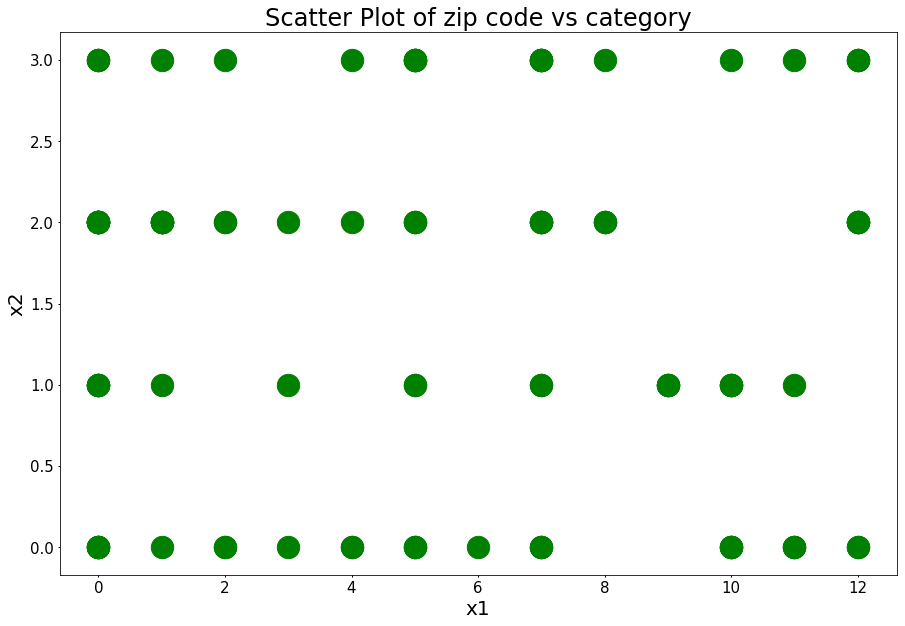

In [24]:
plot_points(raleigh_venues_comb_df['x1'], raleigh_venues_comb_df['x2'], figure_title='Scatter Plot of zip code vs category')

#### Initialize *k*-means - randomly define clusters and add them to plot

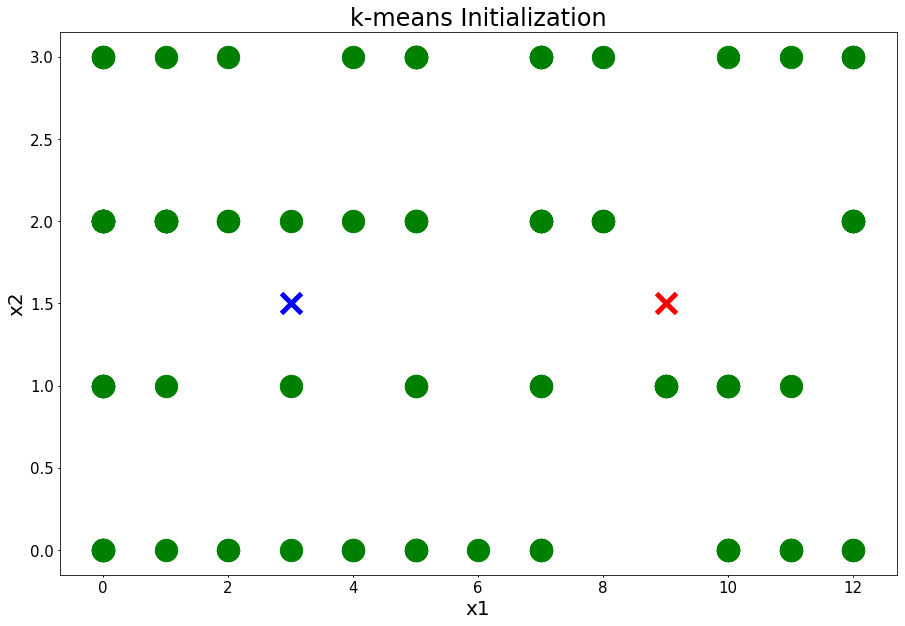

In [25]:
centers = [[3, 1.5], [9, 1.5]]
plot_points(raleigh_venues_comb_df['x1'], raleigh_venues_comb_df['x2'], centers, figure_title='k-means Initialization')

#### Run *k*-means (4-iterations only)

Iteration 1 - Press Enter to update the members of each cluster 


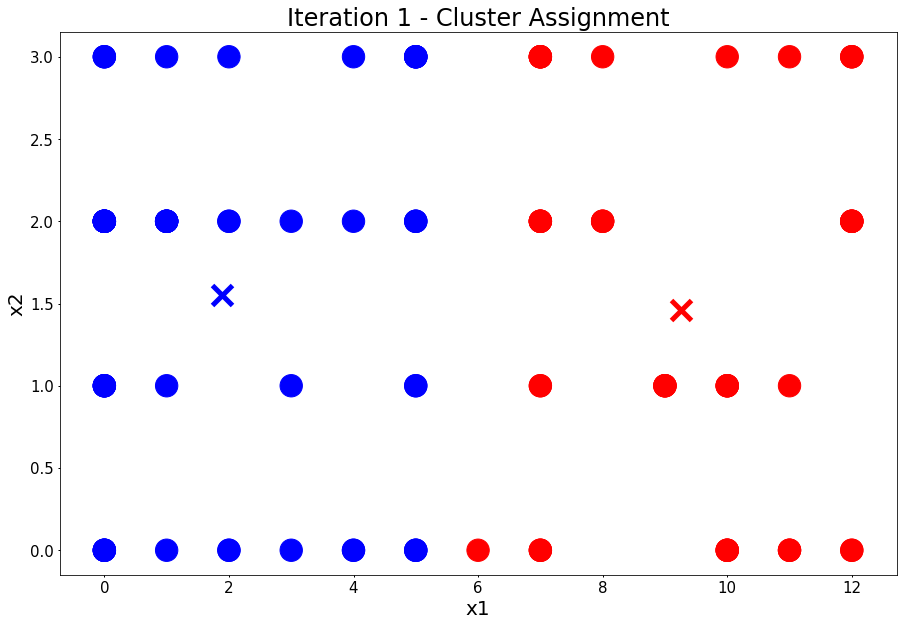

Iteration 1 - Press Enter to update the centers 


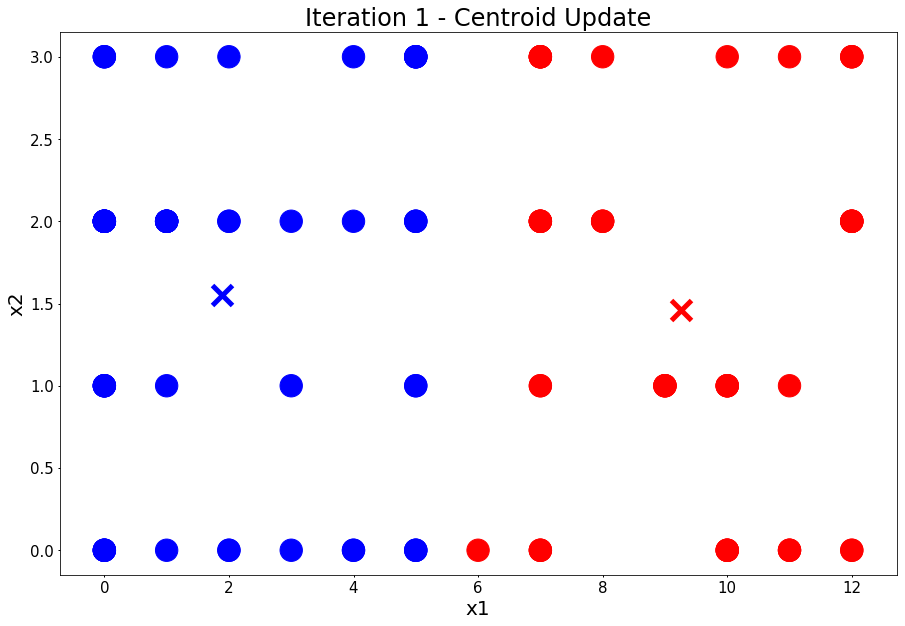

Iteration 2 - Press Enter to update the members of each cluster 


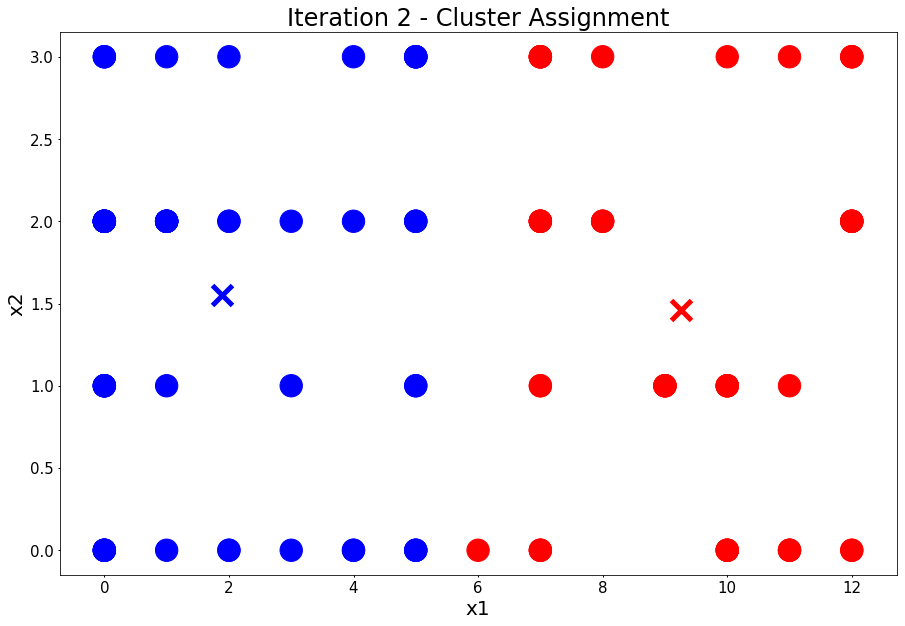

Iteration 2 - Press Enter to update the centers 


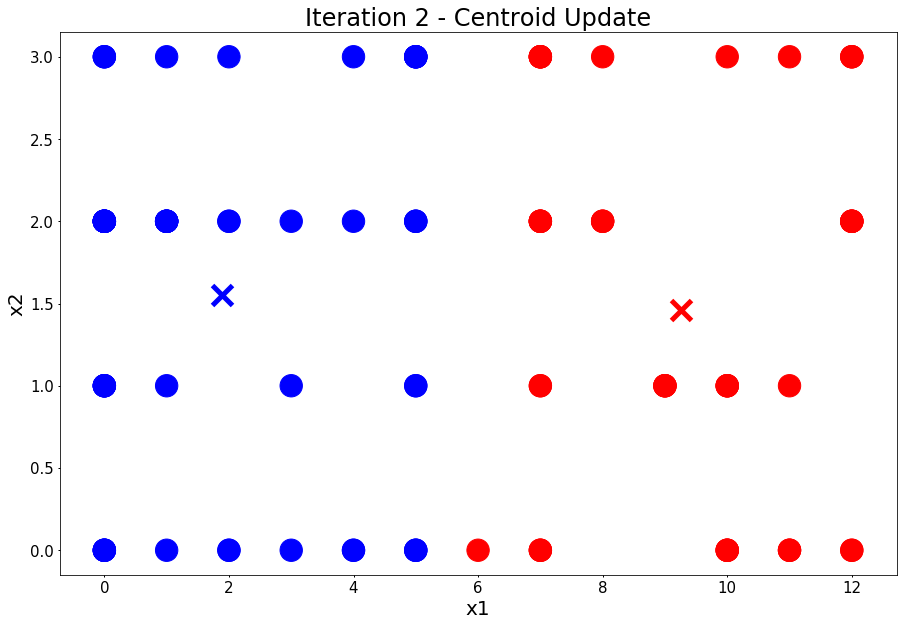

Iteration 3 - Press Enter to update the members of each cluster 


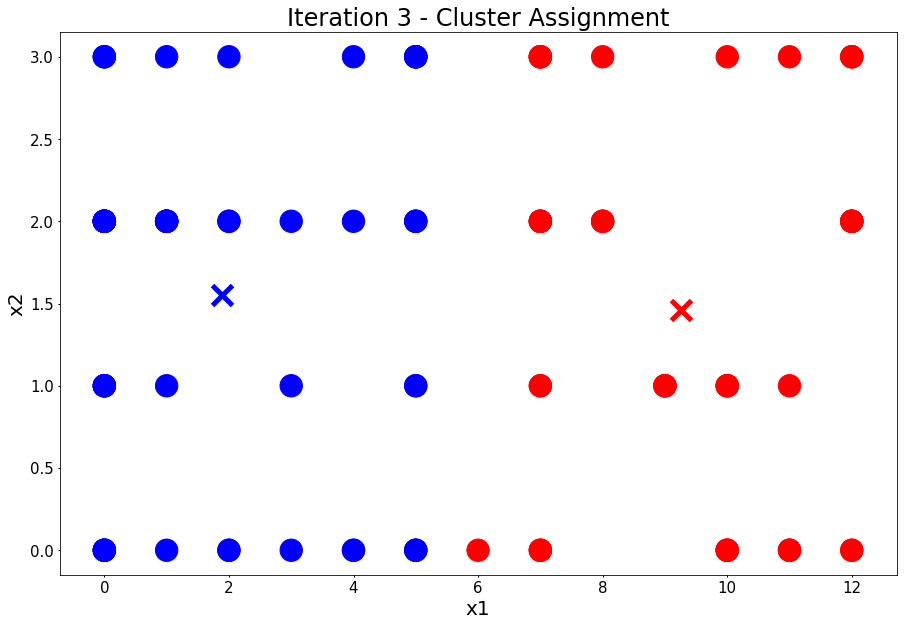

Iteration 3 - Press Enter to update the centers 


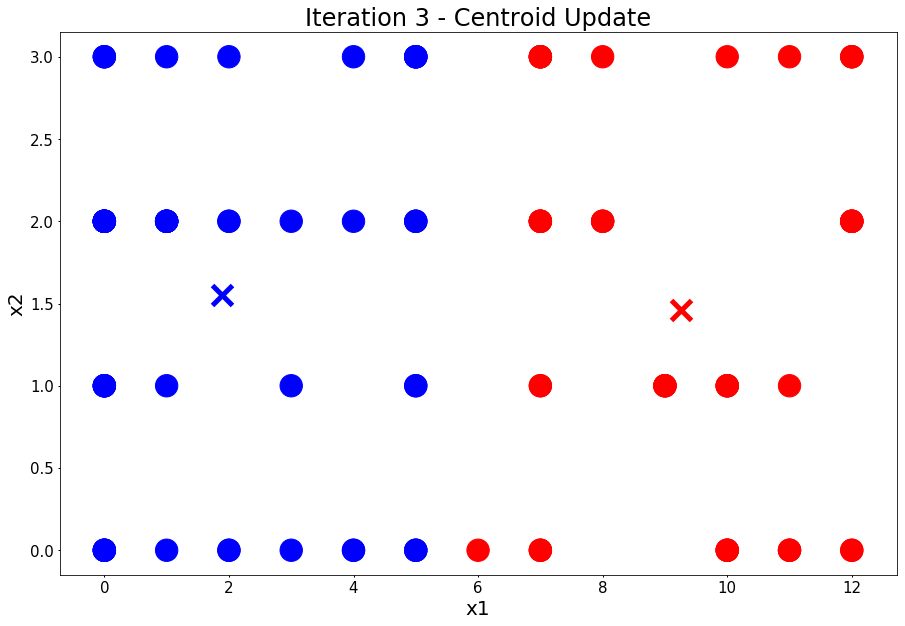

Iteration 4 - Press Enter to update the members of each cluster 


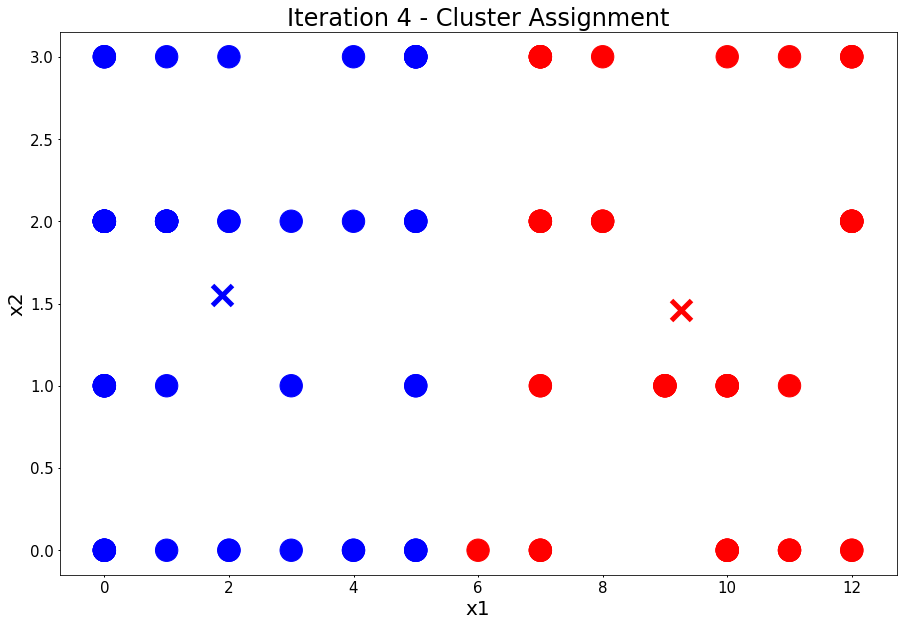

Iteration 4 - Press Enter to update the centers 


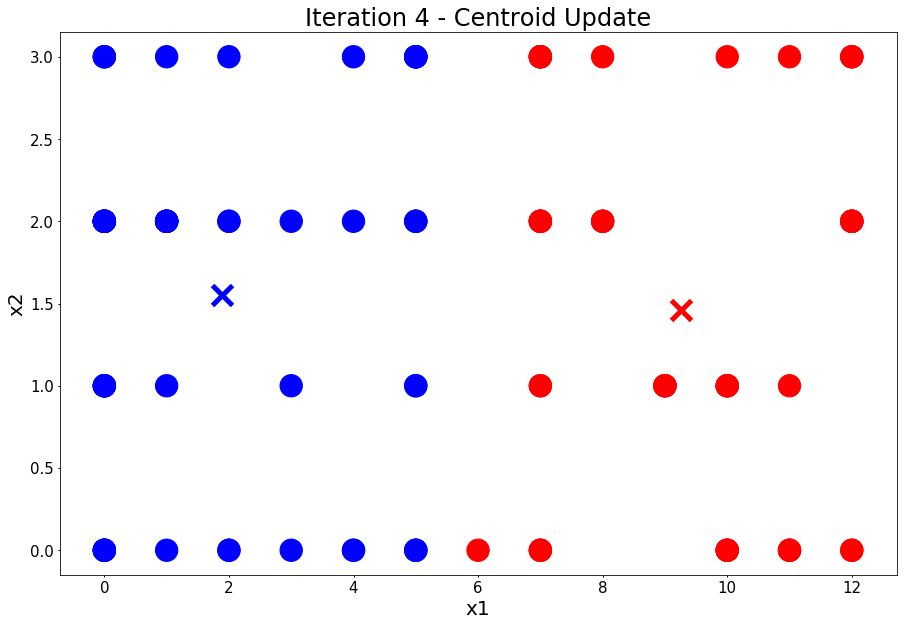

In [29]:
number_of_iterations = 4
for i in range(number_of_iterations):
    input('Iteration {} - Press Enter to update the members of each cluster'.format(i + 1))
    colors, class_of_points = assign_members(raleigh_venues_comb_df['x1'], raleigh_venues_comb_df['x2'], centers)
    title = 'Iteration {} - Cluster Assignment'.format(i + 1)
    plot_points(raleigh_venues_comb_df['x1'], raleigh_venues_comb_df['x2'], centers, colors, figure_title=title)
    input('Iteration {} - Press Enter to update the centers'.format(i + 1))
    centers = update_centers(raleigh_venues_comb_df['x1'], raleigh_venues_comb_df['x2'], class_of_points)
    title = 'Iteration {} - Centroid Update'.format(i + 1)
    plot_points(raleigh_venues_comb_df['x1'], raleigh_venues_comb_df['x2'], centers, colors, figure_title=title)

### Setting up *k*-means

In [53]:
k_means = KMeans(init = "k-means++", n_clusters = 3, n_init = 12)

### Format dataframe to produce  another dataframe with less columns for the X in k-means

In [54]:
X = raleigh_venues_comb_df[['x1', 'x2']]

In [55]:
k_means.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=12, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [56]:
k_means_labels = k_means.labels_
k_means_labels

array([0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2], dtype=int32)

In [57]:
k_means_cluster_centers = k_means.cluster_centers_
k_means_cluster_centers

array([[ 0.70731707,  1.51219512],
       [10.75      ,  1.21428571],
       [ 6.05405405,  1.72972973]])

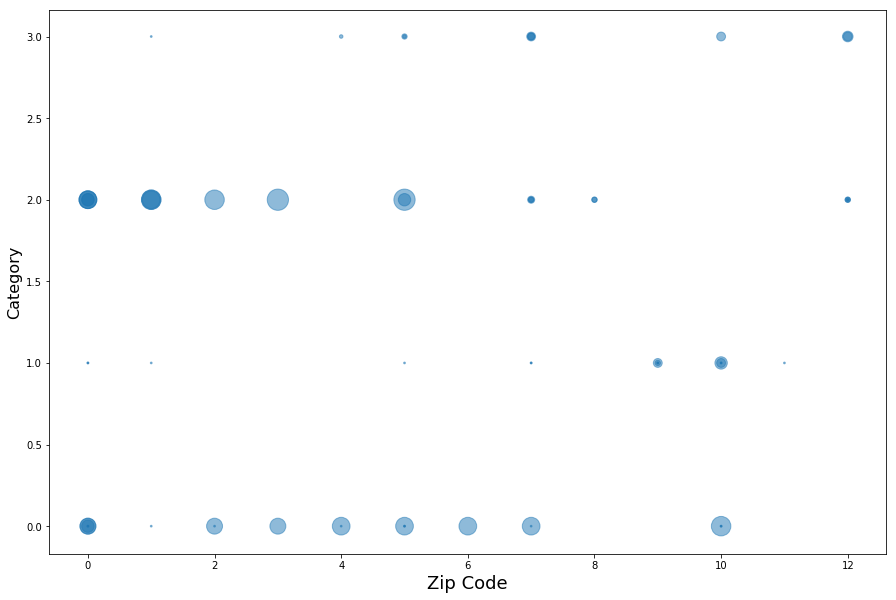

In [58]:
area = np.pi * X**2  
plt.figure(figsize=(15, 10))
plt.scatter(X['x1'], X['x2'], s=area, alpha=0.5)
plt.xlabel('Zip Code', fontsize=18)
plt.ylabel('Category', fontsize=16)

plt.show()

### Elbow Curve method used to determine what the optimal number of clusters are

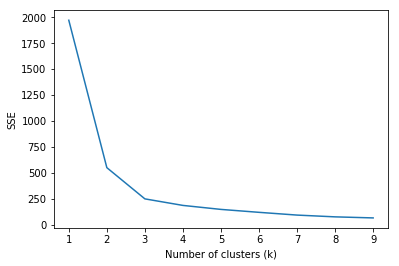

In [59]:
sse={}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(X)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters (k)")
plt.ylabel("SSE")
plt.show()

In [77]:
kclusters = 4
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)
import matplotlib.colors as colors
# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
kcolors = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for x1, x2, zipc, cat in zip(raleigh_venues_comb_df['location.lat'], raleigh_venues_comb_df['location.lng'], raleigh_venues_comb_df['x1'], raleigh_venues_comb_df['x2']):
    label = folium.Popup('Cluster ' + str(cat), parse_html=True)
    folium.CircleMarker(
        [x1, x2],
        radius=5,
        popup=label,
        color=kcolors[cat-1],
        fill=True,
        fill_color=kcolors[cat-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Cluster 0: Caffes - red
### Cluster 1: Italian Restaurants - purple
### Cluster 2: Nightlife - green
### Cluster 3: Shopping - yellow

In [91]:
df = raleigh_venues_comb_df.groupby('location.postalCode').count()
df.sort_values(by='category', ascending=False, inplace=True)
df['category']

location.postalCode
27601    23
27612    15
27609    13
27603    10
27617    10
27615     9
27605     5
27616     5
27607     4
27613     4
27614     4
27606     3
27610     1
Name: category, dtype: int64

## Conclusion:  zip code 27601 seems to have the most active venues for the four categories of Intalian Restaurant, caffes, shopping, and Nightlife